In [1]:
#GAN-> Generative Adversarial Network
import torch
torch.cuda.is_available()

True

In [2]:
import os
IMG_DIR= r'C:\Users\saswa\saswata\ML_Files\AnimeDatasets'

In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [4]:
image_size= 64                  #We will be cropping the images to 64 pixels by 64 pixels for ease of train
batch_size= 128
stats= (0.5,0.5,0.5), (0.5,0.5,0.5)   #Mean and std dev of 0.5 for normalizing the data. 3 tuples for 3 channels of RGB. The pixel range will be -1 to 1

In [5]:
train_ds= ImageFolder(IMG_DIR, transform= T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),                   #Center crop will crop out 64*64 image from the center of the og image
    T.ToTensor(),
    T.Normalize(*stats)
]))
train_dl= DataLoader(train_ds, 
batch_size, 
shuffle=True,           #For randomization of data so that the model is more robust
num_workers=3,
pin_memory=True)

In [6]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [7]:
def denorm(img_tensors):
    return img_tensors*stats[0][0]+stats[1][0]

In [8]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

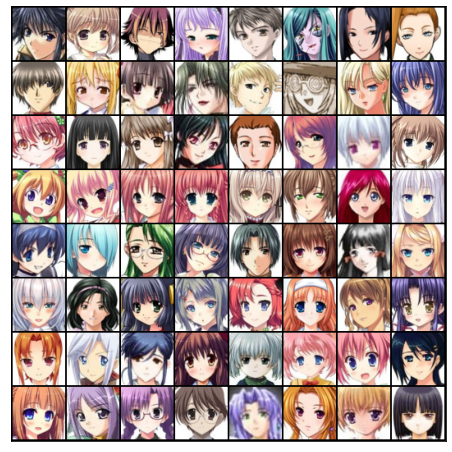

In [9]:
show_batch(train_dl)

In [10]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):                        #Moving tensors to the chosen device
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking= True)

In [11]:
device= get_default_device()
device

device(type='cuda')

In [12]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
train_dl= DeviceDataLoader(train_dl, device)

In [14]:
import torch.nn as nn

In [15]:
discriminator= nn.Sequential(
    #in 3*64*64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias= False),              #3 is the input channel, 64 as output channel
    nn.BatchNorm2d(64),                                                             #Pass the output channel in the batchNorm2D
    nn.LeakyReLU(0.2, inplace= True),                                                #0.2 is the negative slope. In leakyrelu, if x<0, then output is neg_slope*x
    #out 64*32*32
    nn.Conv2d(64, 128, kernel_size=4, stride= 2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()                            #Sigmoid will output either 0 or 1 classifying the image as generated or original
)

In [16]:
discriminator= to_device(discriminator, device)

In [17]:
latent_size= 128

In [18]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),       #ConvTranspose is also called deconvolution
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()                                                                  #tanh act func is used cuz we want the pixel values between -1 and 1
    # out: 3 x 64 x 64
)

In [19]:
def train_discriminator(real_images, opt_d):                                    #opt_d is discriminator optimizer
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = nn.functional.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = nn.functional.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()                                                        #Performs a single optimization step
    return loss.item(), real_score, fake_score

In [20]:
def train_generator(opt_g):                                                 #opt_g is generator optimizer
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = nn.functional.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [21]:
from tqdm.notebook import tqdm                      #This library is just used for crearting progress bars
import torch.nn.functional as F     

In [47]:
fixed_latent= torch.randn(batch_size, latent_size, 1, 1)

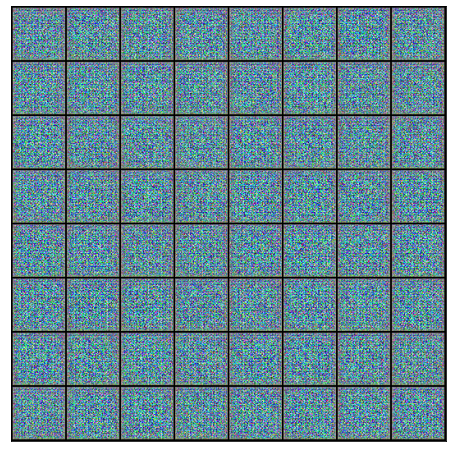

In [37]:
show_images(generator(fixed_latent))                   #randn: Returns a tensor filled with random numbers from a normal distribution with mean 0 and variance 1

In [48]:
def fit(epochs, lr):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))                         #The beta tuple are the beta1 and beta2 values used in Momenttum and RMSprop
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in train_dl:
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        #show_images(generator(fixed_latent))
        
    return losses_g, losses_d, real_scores, fake_scores

In [42]:
lr= 0.0005
epochs= 10

In [49]:
history= fit(epochs, lr)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same